In [ ]:
import pandas as pd
import os
#from helper import *
from tqdm import tqdm
tqdm.monitor_interval = 0
tqdm.pandas()
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
import datasets
from datasets import Dataset, DatasetDict
from datasets import ClassLabel

In [ ]:
#read the dataset
df = pd.read_csv('/content/Entity extraction - merge(1).csv')
df

,Document_Segment,Segment,label
0,1-s2.0-S0301479717300713-main.pdf.tei_48,"In total, 12 documents were identified as rele...",0
1,1-s2.0-S0304387816300670-main.pdf.tei_119,While our model and the specification below fo...,0
2,1-s2.0-S0140196313000608-main.pdf.tei_110,Other areas have experienced a decrease in [cr...,1
3,1-s2.0-S0169204617300270-main.pdf.tei_35,"We use the term ""[urban] sprawl"" to describe a...",0
4,1-s2.0-S095937809800003X-main.pdf.tei_69,"Thus, changes in [land use ]strategies result ...",1
...,...,...,...
156,1-s2.0-S0140196310000893-main.pdf.tei_39,Conversely the decrease in the herbaceous stan...,1
157,1-s2.0-S0169204617300270-main.pdf.tei_26,The Land Administration Project from 2003 to p...,0
158,1-s2.0-S003442571730041X-main.pdf.tei_2,"At present, no studies have considered the imp...",0
159,1-s2.0-S000632071100245X-main.pdf.tei_4,"In fact, some NTFP-providing trees, such as th...",1


In [ ]:
df["label"].value_counts()

label
0    93
1    68
Name: count, dtype: int64

In [ ]:
#Function to clean the dataset
import re

def nettoyer_texte(texte):
    # Utiliser une expression régulière pour trouver et supprimer tout ce qui est entre accolades
    texte_nettoye = re.sub(r'\{.*?\}', ' ', texte)

     # Utiliser une expression régulière pour supprimer toutes les occurrences de '#text':
    texte_nettoye = re.sub(r"'#text':", '', texte_nettoye)

    # Utiliser une expression régulière pour supprimer toutes les occurrences de '@xmlns':
    texte_nettoye = re.sub(r"'@xmlns':", '', texte_nettoye)

     # Utiliser une expression régulière pour supprimer toutes les occurrences de '<variable>: {'
    texte_nettoye = re.sub(r"'\w+':\s*", ' ', texte_nettoye)

      # Supprimer toute suite de plus de deux caractères spéciaux ou espaces
    texte_nettoye = re.sub(r'[^a-zA-Z0-9 .%]+', ' ', texte_nettoye)
    # Nettoyer les espaces en trop
    texte_nettoye = re.sub(r'\s+', ' ', texte_nettoye).strip()
    return texte_nettoye


In [ ]:
df['cleaned_text'] = df['Segment'].apply(nettoyer_texte)
df

,Document_Segment,Segment,label,cleaned_text
0,1-s2.0-S0301479717300713-main.pdf.tei_48,"In total, 12 documents were identified as rele...",0,In total 12 documents were identified as relev...
1,1-s2.0-S0304387816300670-main.pdf.tei_119,While our model and the specification below fo...,0,While our model and the specification below fo...
2,1-s2.0-S0140196313000608-main.pdf.tei_110,Other areas have experienced a decrease in [cr...,1,Other areas have experienced a decrease in cro...
3,1-s2.0-S0169204617300270-main.pdf.tei_35,"We use the term ""[urban] sprawl"" to describe a...",0,We use the term urban sprawl to describe a spe...
4,1-s2.0-S095937809800003X-main.pdf.tei_69,"Thus, changes in [land use ]strategies result ...",1,Thus changes in land use strategies result not...
...,...,...,...,...
156,1-s2.0-S0140196310000893-main.pdf.tei_39,Conversely the decrease in the herbaceous stan...,1,Conversely the decrease in the herbaceous stan...
157,1-s2.0-S0169204617300270-main.pdf.tei_26,The Land Administration Project from 2003 to p...,0,The Land Administration Project from 2003 to p...
158,1-s2.0-S003442571730041X-main.pdf.tei_2,"At present, no studies have considered the imp...",0,At present no studies have considered the impo...
159,1-s2.0-S000632071100245X-main.pdf.tei_4,"In fact, some NTFP-providing trees, such as th...",1,In fact some NTFP providing trees such as the ...


In [ ]:
df["label_encoded"] = pd.Categorical(df["label"], ordered=True).codes

In [ ]:
num_labels = len(set(df["label"]))

In [ ]:
num_labels

2

In [ ]:
!pip install torch transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

#Train/test dataset

In [ ]:
#spli the dataset
idx = [i for i in range(len(df.index))]
ys = df[[ "label"]]
x_train, x_test = train_test_split(idx,
                                   test_size=0.30,
                                   random_state=0,
                                   stratify=ys) # if imbalanced labels, takes into account the proportion of each label


#df['label'] = df[ "relevant"]
df_train = df.iloc[x_train]
df_test =  df.iloc[x_test]
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train[["cleaned_text", "label"]]),
    "test": Dataset.from_pandas(df_test[["cleaned_text", "label"]])
    })

In [ ]:
train_dataset = dataset["train"].shuffle(seed=42)
test_dataset = dataset["test"].shuffle(seed=42)

In [ ]:
"""
    Converts a classification report dictionary into a DataFrame.

    This function processes a classification report dictionary (`classif_report`), which typically includes precision, recall, and F1-scores for different classes, as well as macro and weighted averages, and accuracy. The function extracts the metrics for individual classes, combines them into a DataFrame, and then appends the macro average, weighted average, and accuracy metrics to the DataFrame. The resulting DataFrame contains rows for each class along with the aggregated metrics.

    Parameters:
    - classif_report (dict): A dictionary containing classification metrics. Keys should include metrics for individual classes (e.g., precision, recall, f1-score), as well as 'macro avg', 'weighted avg', and 'accuracy'.

    Returns:
    - pd.DataFrame: A DataFrame where each row represents a class or an aggregate metric (macro average, weighted average), with columns for precision, recall, f1-score, and support, and an additional column for accuracy.
"""
def df_scores_small(classif_report):
    cls = [x for x in classif_report.keys() if x not in ['accuracy', 'macro avg', 'weighted avg']]
    dfs = []
    for key in cls:
        df = pd.DataFrame(classif_report[key], index=[key])
        dfs.append(df)

    final_df = pd.concat(dfs)
    for key in ['macro avg', 'weighted avg']:
        df = pd.DataFrame(classif_report[key], index=[key])
        dfs.append(df)

    final_df = pd.concat(dfs)
    final_df['accuracy'] = classif_report['accuracy']

    return(final_df)

Distribution-based classification

In [ ]:
# Initialize a TF-IDF Vectorizer without any custom preprocessor.
vec = TfidfVectorizer(preprocessor=None)

# Transform the training documents into a document-term matrix using the learned vocabulary.
# The fit_transform method is applied to the training dataset to learn the vocabulary and transform the text.
X_train_tf_idf = vec.fit_transform(train_dataset['cleaned_text'])

# Transform the test documents into a document-term matrix using the previously learned vocabulary.
# The transform method is applied to the test dataset to convert the text into the same feature space as the training data.
X_test_tf_idf = vec.transform(test_dataset['cleaned_text'])


In [ ]:
clf_svm = LinearSVC(class_weight="balanced",loss="hinge",dual = True)
clf_svm.fit(X_train_tf_idf , train_dataset['label'])

LinearSVC(class_weight='balanced', loss='hinge')

In [ ]:
# generate predictions
pred = clf_svm.predict(X_test_tf_idf)

classif_report = classification_report(y_pred=pred, y_true=test_dataset['label'], digits=2, output_dict = True)
classif_report = df_scores_small(classif_report)
classif_report

,precision,recall,f1-score,support,accuracy
1,0.631579,0.666667,0.648649,18,0.535714
2,0.333333,0.300000,0.315789,10,0.535714
macro avg,0.482456,0.483333,0.482219,28,0.535714
weighted avg,0.525063,0.535714,0.529770,28,0.535714


<Axes: >

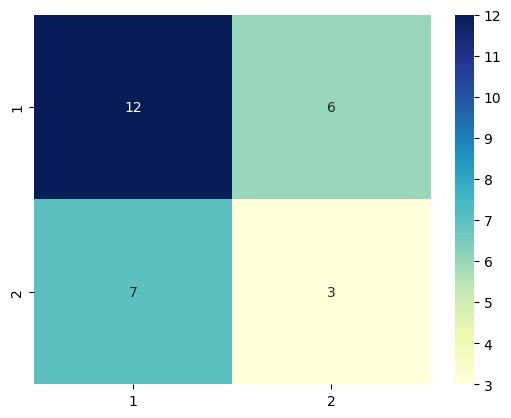

In [ ]:
cm = confusion_matrix(y_true=test_dataset['label'], y_pred=pred)
classes = unique_labels(pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu' , xticklabels=classes , yticklabels = classes)

#Cross Validation Part

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd


X_train_tf_idf = vec.fit_transform(train_dataset['cleaned_text'])
X_test_tf_idf = vec.transform(test_dataset['cleaned_text'])

# Defining the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 150, 200],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

# Initialize StratifiedKFold with random_state for reproducibility
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize Grid Search with the SVM model and the defined parameter grid
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=cv, scoring='accuracy')

# Fitting Grid Search to the training data
grid_search.fit(X_train_tf_idf, train_dataset['label'])

# Best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

# Reinitialize StratifiedKFold for the classification report generation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize the model with the best parameters found by GridSearchCV
best_svm = SVC(**best_parameters, random_state=42)

# Cross-validation predictions
y_pred = cross_val_predict(best_svm, X_train_tf_idf, train_dataset['label'], cv=cv)

# Generate classification report for each fold
fold_reports = []
for fold, (train_index, test_index) in enumerate(cv.split(X_train_tf_idf, train_dataset['label'])):
    y_true_fold = np.array(train_dataset['label'])[test_index]
    y_pred_fold = y_pred[test_index]
    report = classification_report(y_true_fold, y_pred_fold, output_dict=True)
    fold_reports.append(report)
    print(f"Classification Report for Fold {fold + 1}:")
    print(classification_report(y_true_fold, y_pred_fold))

# Train the final model on the entire training dataset using the best parameters
best_svm.fit(X_train_tf_idf, train_dataset['label'])

# Use the trained model to predict the labels of the test set
y_pred_test = best_svm.predict(X_test_tf_idf)

# Generate and print the classification report for the test set
test_report = classification_report(test_dataset['label'], y_pred_test)
print("Classification Report for Test Set:")
print(test_report)

best_parameters, best_score, fold_reports, test_report



Classification Report for Fold 1:
              precision    recall  f1-score   support

           1       0.64      1.00      0.78         9
           2       0.00      0.00      0.00         5

    accuracy                           0.64        14
   macro avg       0.32      0.50      0.39        14
weighted avg       0.41      0.64      0.50        14

Classification Report for Fold 2:
              precision    recall  f1-score   support

           1       0.69      1.00      0.82         9
           2       0.00      0.00      0.00         4

    accuracy                           0.69        13
   macro avg       0.35      0.50      0.41        13
weighted avg       0.48      0.69      0.57        13

Classification Report for Fold 3:
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         8
           2       1.00      0.20      0.33         5

    accuracy                           0.69        13
   macro avg       0.83   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

({'C': 1, 'gamma': 1e-05, 'kernel': 'linear'},
 0.6758241758241758,
 [{'1': {'precision': 0.6428571428571429,
    'recall': 1.0,
    'f1-score': 0.782608695652174,
    'support': 9},
   '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
   'accuracy': 0.6428571428571429,
   'macro avg': {'precision': 0.32142857142857145,
    'recall': 0.5,
    'f1-score': 0.391304347826087,
    'support': 14},
   'weighted avg': {'precision': 0.41326530612244905,
    'recall': 0.6428571428571429,
    'f1-score': 0.5031055900621119,
    'support': 14}},
  {'1': {'precision': 0.6923076923076923,
    'recall': 1.0,
    'f1-score': 0.8181818181818181,
    'support': 9},
   '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4},
   'accuracy': 0.6923076923076923,
   'macro avg': {'precision': 0.34615384615384615,
    'recall': 0.5,
    'f1-score': 0.40909090909090906,
    'support': 13},
   'weighted avg': {'precision': 0.47928994082840237,
    'recall': 0.6923076923076923

#BERT

In [ ]:
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

In [ ]:
# Convert the 'label' column in the DataFrame to categorical codes with ordered categories.
# The 'relevant' column is used as the source for the 'label' column (commented out).
df["label"] = pd.Categorical(df["label"], ordered=True).codes

# Split the DataFrame into training and testing subsets based on the provided indices.
df_train = df.iloc[x_train]
df_test = df.iloc[x_test]

# Create a DatasetDict object containing 'train' and 'test' splits.
# Each split is created from the DataFrame subsets, containing the 'cleaned_text' and 'label' columns.
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train[["cleaned_text", "label"]]),
    "test": Dataset.from_pandas(df_test[["cleaned_text", "label"]])
})


In [ ]:

pretrained_model = "roberta-base"

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer


def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['cleaned_text'], padding=True, truncation=True, max_length=512)
    return tokenized_batch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    my_metrics ={
        "accuracy": accuracy_score(y_pred=predictions, y_true=labels),
    "F1": f1_score(y_pred=predictions, y_true=labels, average = 'weighted')
        }

    labels = [index2label[l] for l in labels.tolist()]
    predictions = [index2label[l] for l in predictions.tolist()]

    # Classification metrics over the epochs
    pd.DataFrame(my_metrics, index=[0]).to_csv(f'{eval_path}.csv', mode='a', header=not os.path.exists(f'{eval_path}.csv'))

    # Classification report (on final epoch)
    classif_report = classification_report(predictions, labels, digits=2, output_dict = True)
    classif_report = df_scores_small(classif_report)
    #print(classif_report)
    classes = unique_labels(predictions, labels)
    classif_report.to_csv(f'{classif_report_path}.csv')

    # Confusion matrix (on final epoch)
    cm = confusion_matrix(y_true=labels, y_pred=predictions, labels=classes)
    cm = pd.DataFrame(cm, columns = classes, index = classes)
    cm.to_csv(f'{cm_path}.csv')

    return my_metrics


In [ ]:
!pip install --upgrade --user accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 1.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
model_name = "roberta_my_model"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=num_labels)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"].shuffle(seed=42)


eval_path = '/tmp/models/{0}_epochsmetrics'.format(model_name)
classif_report_path = '/tmp/modelsl/{0}_cr'.format(model_name)
cm_path = '/tmp/models/{0}_cm'.format(model_name)



training_args = TrainingArguments(
    output_dir="test_trainer",
    #evaluation_strategy="epoch",
    save_strategy = "no",
    num_train_epochs=25,
    load_best_model_at_end =True,
    #per_device_train_batch_size =4,
    #per_device_eval_batch_size =4,
    seed=42,
    report_to= "none"
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

NameError: name 'pretrained_model' is not defined

In [ ]:
trainer.save_model("/tmp/models/{}".format(model_name))

In [ ]:
from transformers import pipeline
model = AutoModelForSequenceClassification.from_pretrained("./tmp/models/{}".format(model_name), force_download=True)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
clf = pipeline("text-classification", model = model, tokenizer=tokenizer, truncation = True, max_length = 512)

In [ ]:
df_test['label'] = df_test['label'].astype(str)

<ipython-input-86-356024d0fcfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['label'] = df_test['label'].astype(str)


In [ ]:
df_test['label']

87     1
152    0
132    1
45     1
111    0
17     1
155    0
42     0
159    1
79     0
90     1
55     0
107    0
41     0
18     1
83     0
117    0
97     0
154    0
153    1
110    1
109    1
80     0
33     0
160    1
105    0
151    1
60     1
70     0
7      1
150    0
2      1
67     0
147    1
115    0
114    0
157    0
27     0
48     1
20     0
49     0
9      1
25     1
137    0
76     0
38     0
126    1
68     0
101    1
Name: label, dtype: object

In [ ]:
conv_label = {'LABEL_0':"0",
              'LABEL_1':"1"}

pred_bert = []
for index, row in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    p = clf(row['cleaned_text'])[0]['label']
    pred_bert.append(conv_label[p])

100%|██████████| 49/49 [00:10<00:00,  4.55it/s]


In [ ]:
print(df_test['label'].dtype)
print(type(pred_bert))
print(set(df_test['label']))
print(set(pred_bert))

object
<class 'list'>
{'1', '0'}
{'1', '0'}


In [ ]:
# Debugging output
print("DataFrame labels dtype:", df_test['label'].dtype)
print("Type of pred_bert:", type(pred_bert))
print("Unique labels in DataFrame:", set(df_test['label']))
print("Unique labels in pred_bert:", set(pred_bert))

# Additional debugging to verify individual label values
print("Actual DataFrame labels:", df_test['label'].tolist())
print("Predicted labels:", pred_bert)

DataFrame labels dtype: object
Type of pred_bert: <class 'list'>
Unique labels in DataFrame: {'1', '0'}
Unique labels in pred_bert: {'1', '0'}
Actual DataFrame labels: ['1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0']
Predicted labels: ['1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '0']


In [ ]:
classif_report = classification_report(y_pred=pred_bert, y_true=df_test['label'], digits=2, output_dict = True)
classif_report = df_scores_small(classif_report)
classif_report

,precision,recall,f1-score,support,accuracy
0,0.692308,0.964286,0.805970,28,0.734694
1,0.900000,0.428571,0.580645,21,0.734694
macro avg,0.796154,0.696429,0.693308,49,0.734694
weighted avg,0.781319,0.734694,0.709402,49,0.734694


Misclassified samples:


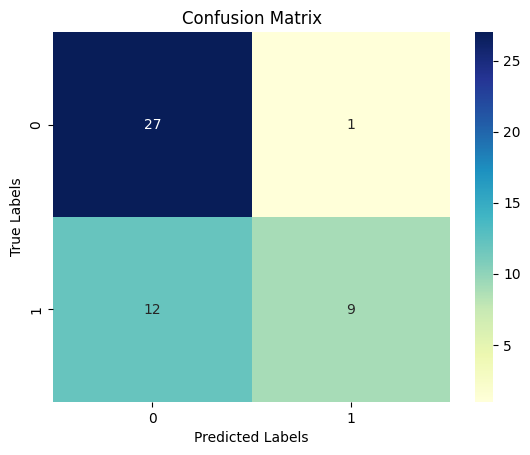

In [ ]:
# Identify misclassified samples
misclassified_indices = [index for index, (true, pred) in enumerate(zip(df_test['label'], pred_bert)) if true != pred]
misclassified_df = df_test.iloc[misclassified_indices].copy()

# Print or return the misclassified samples
print("Misclassified samples:")
# Add a column for the predicted labels
misclassified_df['predicted_label'] = [pred_bert[i] for i in misclassified_indices]

# Optionally, display the confusion matrix
cm = confusion_matrix(y_true=df_test['label'], y_pred=pred_bert)
classes = unique_labels(df_test['label'], pred_bert)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
misclassified_df

,Document_Segment,Segment,label,cleaned_text,label_encoded,predicted_label
87,1-s2.0-S0169204617300270-main.pdf.tei_6,The remote sensing analysis revealed that [urb...,1,The remote sensing analysis revealed that urba...,1,0
132,1-s2.0-S0304387816300670-main.pdf.tei_207,The dependent variable is growth in the [urban...,1,The dependent variable is growth in the urbani...,1,0
111,1-s2.0-S0168192311001122-main.pdf.tei_53,Since livestock does not play a major role in ...,0,Since livestock does not play a major role in ...,0,1
17,1-s2.0-S0301479717300713-main.pdf.tei_139,"P9: We know that [urbanisation] is coming, it\...",1,P9 We know that urbanisation is coming it s gr...,1,0
90,1-s2.0-S095937809800003X-main.pdf.tei_50,"Thus, the coherence between spatially related ...",1,Thus the coherence between spatially related s...,1,0
18,1-s2.0-S0301479717300713-main.pdf.tei_181,Temperature variability P3: So it has the pote...,1,Temperature variability P3 So it has the poten...,1,0
153,1-s2.0-S0140196322000143-main.pdf.tei_84,The plots were only cropped one year and with ...,1,The plots were only cropped one year and with ...,1,0
109,1-s2.0-S095937809800003X-main.pdf.tei_4,"(1993)'}], '#text': ""An increase of land under...",1,1993 An increase of land under cultivation can...,1,0
2,1-s2.0-S0140196313000608-main.pdf.tei_110,Other areas have experienced a decrease in [cr...,1,Other areas have experienced a decrease in cro...,1,0
147,1-s2.0-S030438781000043X-mainext.pdf.tei_61,"In his study of the ICRISAT villages, he argue...",1,In his study of the ICRISAT villages he argues...,1,0


After the model is saved you can use this part to make predictions in unseen data, just put the dataset you want to try and the model you want to use

# Prediction for first round (when 1 and 2 is merged in only one class)


In [ ]:
import zipfile

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/1-2024/Internship/models/models_1_2.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
model_name = "roberta_my_model"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model_name = "roberta_my_model 0-1"
model_path = "/tmp/{}".format(model_name)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_path, force_download=True)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Create the pipeline
clf = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True, max_length=512)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
import pandas as pd

df_out = pd.read_csv('/content/full_dataset.csv')
df_out

,doccano task,Segment,label
0,1-s2.0-S0301479717300713-main.pdf.tei_48,"In total, 12 documents were identified as rele...",0
1,1-s2.0-S0304387816300670-main.pdf.tei_119,While our model and the specification below fo...,0
2,1-s2.0-S0140196313000608-main.pdf.tei_110,Other areas have experienced a decrease in [cr...,1
3,1-s2.0-S0169204617300270-main.pdf.tei_35,"We use the term ""[urban] sprawl"" to describe a...",0
4,1-s2.0-S095937809800003X-main.pdf.tei_69,"Thus, changes in [land use ]strategies result ...",2
...,...,...,...
319,1-s2.0-S0264837701000205-main.pdf.tei_59,Substantial changes in [land cover] and [land ...,1
320,1-s2.0-S0264837701000205-main.pdf.tei_59pt_2,"#text': 'In general, [land use ]pattern change...",0
321,1-s2.0-S0303243414001718-main.pdf.tei_24,During this time the land required for [agricu...,2
322,1-s2.0-S0304387816300670-main.pdf.tei_5,Reduced farm incomes from negative shocks redu...,0


In [ ]:
#df_out['cleaned_text'] = df_out['Segment'].apply(nettoyer_texte)

df_out.loc[164:, 'cleaned_text'] = df_out.loc[164:, 'Segment'].apply(nettoyer_texte)
df_out

,doccano task,Segment,label,cleaned_text
0,1-s2.0-S0301479717300713-main.pdf.tei_48,"In total, 12 documents were identified as rele...",0,NaN
1,1-s2.0-S0304387816300670-main.pdf.tei_119,While our model and the specification below fo...,0,NaN
2,1-s2.0-S0140196313000608-main.pdf.tei_110,Other areas have experienced a decrease in [cr...,1,NaN
3,1-s2.0-S0169204617300270-main.pdf.tei_35,"We use the term ""[urban] sprawl"" to describe a...",0,NaN
4,1-s2.0-S095937809800003X-main.pdf.tei_69,"Thus, changes in [land use ]strategies result ...",2,NaN
...,...,...,...,...
319,1-s2.0-S0264837701000205-main.pdf.tei_59,Substantial changes in [land cover] and [land ...,1,Substantial changes in land cover and land use...
320,1-s2.0-S0264837701000205-main.pdf.tei_59pt_2,"#text': 'In general, [land use ]pattern change...",0,text In general land use pattern changes may n...
321,1-s2.0-S0303243414001718-main.pdf.tei_24,During this time the land required for [agricu...,2,During this time the land required for agricul...
322,1-s2.0-S0304387816300670-main.pdf.tei_5,Reduced farm incomes from negative shocks redu...,0,Reduced farm incomes from negative shocks redu...


In [ ]:
df_out = df_out.loc[164:].reset_index(drop=True)
df_out

,doccano task,Segment,label,cleaned_text
0,1-s2.0-S0167880913003502-main.pdf.tei_123,Whilst Blanco-Canqui and stress those similar ...,0,Whilst Blanco Canqui and stress those similar ...
1,1-s2.0-S030438781000043X-mainext.pdf.tei_75,"In addition to land ownership, the regressions...",0,In addition to land ownership the regressions ...
2,1-s2.0-S030438781000043X-mainext.pdf.tei_106,"LSMS 1985-88'}, 'Inputs', None, None, None, No...",0,LSMS 1985 88 Inputs None None None None None N...
3,1-s2.0-S0167880913003502-main.pdf.tei_72,Datasets from such studies are needed to inves...,0,Datasets from such studies are needed to inves...
4,1-s2.0-S000632071100245X-main.pdf.tei_15,leiocarpa do not lose the ability to sprout af...,0,leiocarpa do not lose the ability to sprout af...
...,...,...,...,...
155,1-s2.0-S0264837701000205-main.pdf.tei_59,Substantial changes in [land cover] and [land ...,1,Substantial changes in land cover and land use...
156,1-s2.0-S0264837701000205-main.pdf.tei_59pt_2,"#text': 'In general, [land use ]pattern change...",0,text In general land use pattern changes may n...
157,1-s2.0-S0303243414001718-main.pdf.tei_24,During this time the land required for [agricu...,2,During this time the land required for agricul...
158,1-s2.0-S0304387816300670-main.pdf.tei_5,Reduced farm incomes from negative shocks redu...,0,Reduced farm incomes from negative shocks redu...


In [ ]:
# Make predictions and add them to a new column in the DataFrame
df_out['predictions'] = df_out['cleaned_text'].apply(lambda x: clf(x)[0]['label'])

# Display the DataFrame with the new predictions column
print(df_out.head())

                                   doccano task  \
0     1-s2.0-S0167880913003502-main.pdf.tei_123   
1   1-s2.0-S030438781000043X-mainext.pdf.tei_75   
2  1-s2.0-S030438781000043X-mainext.pdf.tei_106   
3      1-s2.0-S0167880913003502-main.pdf.tei_72   
4      1-s2.0-S000632071100245X-main.pdf.tei_15   

                                             Segment  label  \
0  Whilst Blanco-Canqui and stress those similar ...      0   
1  In addition to land ownership, the regressions...      0   
2  LSMS 1985-88'}, 'Inputs', None, None, None, No...      0   
3  Datasets from such studies are needed to inves...      0   
4  leiocarpa do not lose the ability to sprout af...      0   

                                        cleaned_text predictions  
0  Whilst Blanco Canqui and stress those similar ...     LABEL_0  
1  In addition to land ownership the regressions ...     LABEL_0  
2  LSMS 1985 88 Inputs None None None None None N...     LABEL_0  
3  Datasets from such studies are needed to in

In [ ]:
df_out.tail()

,doccano task,Segment,label,cleaned_text,predictions
155,1-s2.0-S0264837701000205-main.pdf.tei_59,Substantial changes in [land cover] and [land ...,1,Substantial changes in land cover and land use...,LABEL_1
156,1-s2.0-S0264837701000205-main.pdf.tei_59pt_2,"#text': 'In general, [land use ]pattern change...",0,text In general land use pattern changes may n...,LABEL_1
157,1-s2.0-S0303243414001718-main.pdf.tei_24,During this time the land required for [agricu...,2,During this time the land required for agricul...,LABEL_1
158,1-s2.0-S0304387816300670-main.pdf.tei_5,Reduced farm incomes from negative shocks redu...,0,Reduced farm incomes from negative shocks redu...,LABEL_0
159,1-s2.0-S0006320709005400-main.pdf.tei_96,"Across plant, invertebrate and vertebrate grou...",0,Across plant invertebrate and vertebrate group...,LABEL_1


In [ ]:
# Filter the DataFrame to only include rows with LABEL_1 predictions
df_label_1 = df_out[df_out['predictions'] == 'LABEL_1']

# Display the new DataFrame with only LABEL_1 predictions
print(df_label_1.head())

                                   doccano task  \
6       1-s2.0-S0264837715302131-main.pdf.tei_6   
7      1-s2.0-S016788090800131X-main.pdf.tei_44   
8      1-s2.0-S0308521X12000157-main.pdf.tei_13   
10     1-s2.0-S0264837701000205-main.pdf.tei_38   
11  1-s2.0-S030438781000043X-mainext.pdf.tei_91   

                                              Segment  label  \
6   In the period 1975-1990, 1.28 million ha (26%)...      2   
7   At the local scale, the size of [crop] and gra...      2   
8   In fact, a major reason why farmers grow [cott...      2   
10  According to the Fulbe, [agriculture] demands ...      0   
11  In Burkina Faso, supposedly more "secure" land...      1   

                                         cleaned_text predictions  
6   In the period 1975 1990 1.28 million ha 26% of...     LABEL_1  
7   At the local scale the size of crop and grazin...     LABEL_1  
8   In fact a major reason why farmers grow cotton...     LABEL_1  
10  According to the Fulbe agricultu

In [ ]:
df_label_1

,doccano task,Segment,label,cleaned_text,predictions
6,1-s2.0-S0264837715302131-main.pdf.tei_6,"In the period 1975-1990, 1.28 million ha (26%)...",2,In the period 1975 1990 1.28 million ha 26% of...,LABEL_1
7,1-s2.0-S016788090800131X-main.pdf.tei_44,"At the local scale, the size of [crop] and gra...",2,At the local scale the size of crop and grazin...,LABEL_1
8,1-s2.0-S0308521X12000157-main.pdf.tei_13,"In fact, a major reason why farmers grow [cott...",2,In fact a major reason why farmers grow cotton...,LABEL_1
10,1-s2.0-S0264837701000205-main.pdf.tei_38,"According to the Fulbe, [agriculture] demands ...",0,According to the Fulbe agriculture demands har...,LABEL_1
11,1-s2.0-S030438781000043X-mainext.pdf.tei_91,"In Burkina Faso, supposedly more ""secure"" land...",1,In Burkina Faso supposedly more secure land in...,LABEL_1
...,...,...,...,...,...
154,1-s2.0-S0304387816300670-main.pdf.tei_155,It is thus possible the [urbanization] we see ...,0,It is thus possible the urbanization we see is...,LABEL_1
155,1-s2.0-S0264837701000205-main.pdf.tei_59,Substantial changes in [land cover] and [land ...,1,Substantial changes in land cover and land use...,LABEL_1
156,1-s2.0-S0264837701000205-main.pdf.tei_59pt_2,"#text': 'In general, [land use ]pattern change...",0,text In general land use pattern changes may n...,LABEL_1
157,1-s2.0-S0303243414001718-main.pdf.tei_24,During this time the land required for [agricu...,2,During this time the land required for agricul...,LABEL_1


#Predictions for #2

In [ ]:
model_name = "roberta_my_model1-2"
model_path = "/tmp/{}".format(model_name)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_path, force_download=True)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Create the pipeline
clf = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True, max_length=512)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
df_label_1['predictions_1'] = df_label_1['cleaned_text'].apply(lambda x: clf(x)[0]['label'])
df_label_1

<ipython-input-22-81c1bb0939cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_1['predictions_1'] = df_label_1['cleaned_text'].apply(lambda x: clf(x)[0]['label'])


,doccano task,Segment,label,cleaned_text,predictions,predictions_1
6,1-s2.0-S0264837715302131-main.pdf.tei_6,"In the period 1975-1990, 1.28 million ha (26%)...",2,In the period 1975 1990 1.28 million ha 26% of...,LABEL_1,LABEL_1
7,1-s2.0-S016788090800131X-main.pdf.tei_44,"At the local scale, the size of [crop] and gra...",2,At the local scale the size of crop and grazin...,LABEL_1,LABEL_1
8,1-s2.0-S0308521X12000157-main.pdf.tei_13,"In fact, a major reason why farmers grow [cott...",2,In fact a major reason why farmers grow cotton...,LABEL_1,LABEL_1
10,1-s2.0-S0264837701000205-main.pdf.tei_38,"According to the Fulbe, [agriculture] demands ...",0,According to the Fulbe agriculture demands har...,LABEL_1,LABEL_0
11,1-s2.0-S030438781000043X-mainext.pdf.tei_91,"In Burkina Faso, supposedly more ""secure"" land...",1,In Burkina Faso supposedly more secure land in...,LABEL_1,LABEL_0
...,...,...,...,...,...,...
154,1-s2.0-S0304387816300670-main.pdf.tei_155,It is thus possible the [urbanization] we see ...,0,It is thus possible the urbanization we see is...,LABEL_1,LABEL_0
155,1-s2.0-S0264837701000205-main.pdf.tei_59,Substantial changes in [land cover] and [land ...,1,Substantial changes in land cover and land use...,LABEL_1,LABEL_0
156,1-s2.0-S0264837701000205-main.pdf.tei_59pt_2,"#text': 'In general, [land use ]pattern change...",0,text In general land use pattern changes may n...,LABEL_1,LABEL_0
157,1-s2.0-S0303243414001718-main.pdf.tei_24,During this time the land required for [agricu...,2,During this time the land required for agricul...,LABEL_1,LABEL_1


In [ ]:
# Replace 'LABEL_0' with 1 and 'LABEL_1' with 2
df_label_1['predictions_1'] = df_label_1['predictions_1'].replace({'LABEL_0': 1, 'LABEL_1': 2})

# Display the updated DataFrame
print(df_label_1.head())

                                   doccano task  \
6       1-s2.0-S0264837715302131-main.pdf.tei_6   
7      1-s2.0-S016788090800131X-main.pdf.tei_44   
8      1-s2.0-S0308521X12000157-main.pdf.tei_13   
10     1-s2.0-S0264837701000205-main.pdf.tei_38   
11  1-s2.0-S030438781000043X-mainext.pdf.tei_91   

                                              Segment  label  \
6   In the period 1975-1990, 1.28 million ha (26%)...      2   
7   At the local scale, the size of [crop] and gra...      2   
8   In fact, a major reason why farmers grow [cott...      2   
10  According to the Fulbe, [agriculture] demands ...      0   
11  In Burkina Faso, supposedly more "secure" land...      1   

                                         cleaned_text predictions  \
6   In the period 1975 1990 1.28 million ha 26% of...     LABEL_1   
7   At the local scale the size of crop and grazin...     LABEL_1   
8   In fact a major reason why farmers grow cotton...     LABEL_1   
10  According to the Fulbe agric

<ipython-input-23-07858a16a606>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_1['predictions_1'] = df_label_1['predictions_1'].replace({'LABEL_0': 1, 'LABEL_1': 2})


In [ ]:
df_label_1

,doccano task,Segment,label,cleaned_text,predictions,predictions_1
6,1-s2.0-S0264837715302131-main.pdf.tei_6,"In the period 1975-1990, 1.28 million ha (26%)...",2,In the period 1975 1990 1.28 million ha 26% of...,LABEL_1,2
7,1-s2.0-S016788090800131X-main.pdf.tei_44,"At the local scale, the size of [crop] and gra...",2,At the local scale the size of crop and grazin...,LABEL_1,2
8,1-s2.0-S0308521X12000157-main.pdf.tei_13,"In fact, a major reason why farmers grow [cott...",2,In fact a major reason why farmers grow cotton...,LABEL_1,2
10,1-s2.0-S0264837701000205-main.pdf.tei_38,"According to the Fulbe, [agriculture] demands ...",0,According to the Fulbe agriculture demands har...,LABEL_1,1
11,1-s2.0-S030438781000043X-mainext.pdf.tei_91,"In Burkina Faso, supposedly more ""secure"" land...",1,In Burkina Faso supposedly more secure land in...,LABEL_1,1
...,...,...,...,...,...,...
154,1-s2.0-S0304387816300670-main.pdf.tei_155,It is thus possible the [urbanization] we see ...,0,It is thus possible the urbanization we see is...,LABEL_1,1
155,1-s2.0-S0264837701000205-main.pdf.tei_59,Substantial changes in [land cover] and [land ...,1,Substantial changes in land cover and land use...,LABEL_1,1
156,1-s2.0-S0264837701000205-main.pdf.tei_59pt_2,"#text': 'In general, [land use ]pattern change...",0,text In general land use pattern changes may n...,LABEL_1,1
157,1-s2.0-S0303243414001718-main.pdf.tei_24,During this time the land required for [agricu...,2,During this time the land required for agricul...,LABEL_1,2


In [ ]:
df_label_1.to_csv('data_label_unseen.csv', index=False)

In [ ]:
df_label_1[df_label_1['predictions_1']==1]

,doccano task,Segment,label,cleaned_text,predictions,predictions_1
10,1-s2.0-S0264837701000205-main.pdf.tei_38,"According to the Fulbe, [agriculture] demands ...",0,According to the Fulbe agriculture demands har...,LABEL_1,1
11,1-s2.0-S030438781000043X-mainext.pdf.tei_91,"In Burkina Faso, supposedly more ""secure"" land...",1,In Burkina Faso supposedly more secure land in...,LABEL_1,1
14,1-s2.0-S0140196310000893-main.pdf.tei_8,The interrelations between [savanna] fire regi...,0,The interrelations between savanna fire regime...,LABEL_1,1
19,1-s2.0-S0006320709005400-main.pdf.tei_111,"), implying that in this region significant op...",0,implying that in this region significant oppor...,LABEL_1,1
21,1-s2.0-S0304387816300670-main.pdf.tei_42,Falling precipitation and rising temperatures ...,1,Falling precipitation and rising temperatures ...,LABEL_1,1
27,1-s2.0-S0303243414001718-main.pdf.tei_12,The population density has increased during th...,1,The population density has increased during th...,LABEL_1,1
40,1-s2.0-S0304387816300670-main.pdf.tei_117,We expect the negative effect of moisture grow...,1,We expect the negative effect of moisture grow...,LABEL_1,1
46,1-s2.0-S235198941500102X-main.pdf.tei_57,The main finding of this study is the loss of ...,2,The main finding of this study is the loss of ...,LABEL_1,1
48,1-s2.0-S0264837701000205-main.pdf.tei_60,"Even in subsistence agricultural systems, chan...",0,Even in subsistence agricultural systems chang...,LABEL_1,1
61,1-s2.0-S0304387816300670-main.pdf.tei_58,If the [city] has a tiny or non-existent trade...,0,If the city has a tiny or non existent traded ...,LABEL_1,1


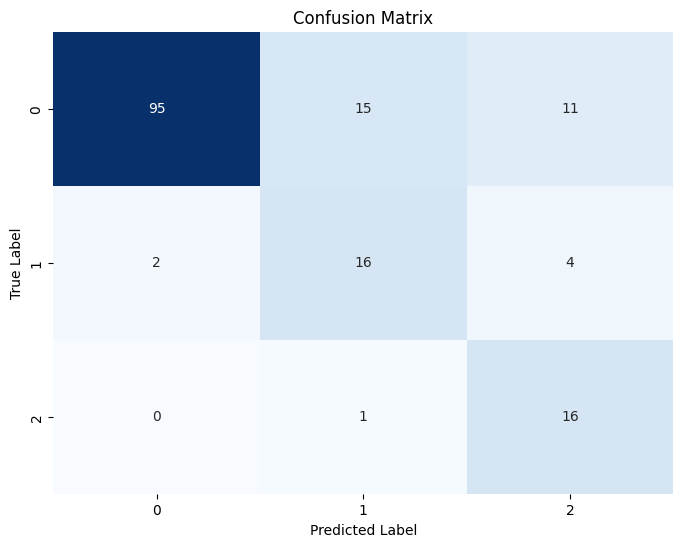

In [ ]:
df = pd.read_csv('/content/predicted_vs_real.csv')
conf_matrix = confusion_matrix(df['real_label'], df['predicted '])

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Step 3: Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(df['real_label'], df['predicted '])
class_report = classification_report(df['real_label'], df['predicted '], target_names=['Class 0', 'Class 1', 'Class 2'])

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}')

# Print the classification report (Precision, Recall, F1-Score for each class)
print('Classification Report:')
print(class_report)

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.79      0.87       121
     Class 1       0.50      0.73      0.59        22
     Class 2       0.52      0.94      0.67        17

    accuracy                           0.79       160
   macro avg       0.67      0.82      0.71       160
weighted avg       0.86      0.79      0.81       160



Grid Search

#In this part